###  1. 빅마트체인은 여러도시에 10개의 매장을 가지고 있고 1559개의 상품을 취급하고 있습니다. 매장의 세일데이터를 이용하여 세일을 예측하는 여러 회귀모델로 결정계수(R Square), 평가지표(MSE, RMSE, MAE)를 엑셀로 만들어서 소스파일과 함께 제출하시오. 또한 train, validation, test 테이터를 생성(데이터 분할은 8:2)하여 각 데이터별(train, validation, test) R Square 점수를 시각화 한후에 평가 결과(쥬피터 노트북)를 작성하세요 (데이터 분할은 Random_State=42 적용)

In [1]:
import pandas as pd
bigmt = pd.read_csv('bigmart_train.csv')

bigmt.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


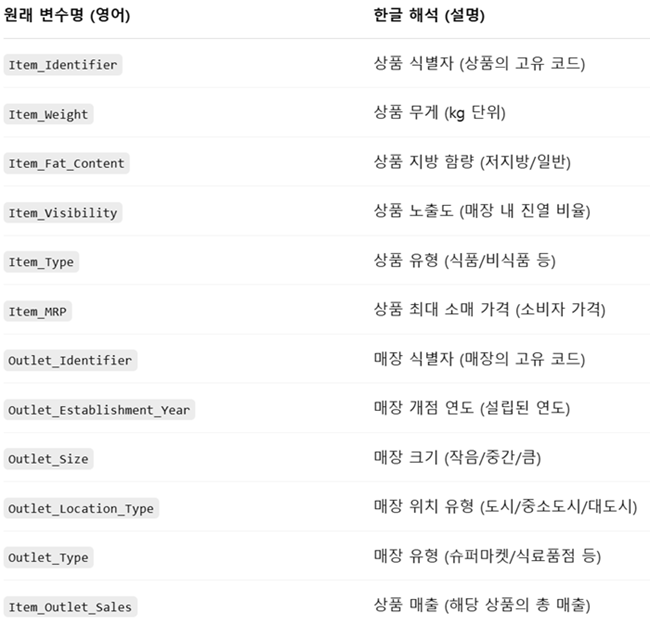

In [2]:
bigmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [3]:
bigmt.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### 결측치 처리하기

#### 상품무게 결측치 처리

In [4]:
# Item_Identifier 와 Item_Type이 모두 같은 경우 평균값으로 채우기
bigmt['Item_Weight'] = bigmt.groupby(['Item_Identifier', 'Item_Type'])['Item_Weight'].transform(lambda x: x.fillna(x.mean()))

# 그래도 결측치 값이 있으면 Item_Type 기준 평균값 채우기
bigmt['Item_Weight'] = bigmt.groupby('Item_Type')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))

print(bigmt['Item_Weight'].isnull().sum())

0


#### 매장 크기 결측치 처리하기

In [5]:
print(bigmt.groupby("Outlet_Type")["Outlet_Size"].value_counts())

Outlet_Type        Outlet_Size
Grocery Store      Small           528
Supermarket Type1  Small          1860
                   High            932
                   Medium          930
Supermarket Type2  Medium          928
Supermarket Type3  Medium          935
Name: count, dtype: int64


In [6]:
print(bigmt.groupby("Outlet_Location_Type")["Outlet_Size"].value_counts())

Outlet_Location_Type  Outlet_Size
Tier 1                Small          1458
                      Medium          930
Tier 2                Small           930
Tier 3                Medium         1863
                      High            932
Name: count, dtype: int64


In [7]:
missing_ratio = bigmt["Outlet_Size"].isnull().sum() / len(bigmt) * 100
print(f"결측치 비율: {missing_ratio:.2f}%")

결측치 비율: 28.28%


In [8]:
# 매장 유형과 위치 유형별로 Outlet_Size의 최빈값 계산
size_mode = bigmt.groupby(["Outlet_Type", "Outlet_Location_Type"])["Outlet_Size"].agg(lambda x: x.mode()[0] if not x.mode().empty else "Unknown")

# 매장 유형 + 위치 유형 조합별 최빈값으로 채우기
def fill_outlet_size(row):
    if pd.isnull(row['Outlet_Size']):
        return size_mode.get((row['Outlet_Type'], row['Outlet_Location_Type']), 'Unknown')
    return row['Outlet_Size']

bigmt['Outlet_Size'] = bigmt.apply(fill_outlet_size, axis=1)

#그래도 채우지 못한 값은 최종적으로 'Unknown'으로 대체
bigmt['Outlet_Size'] = bigmt['Outlet_Size'].fillna('Unknown')

# 확인
print(bigmt['Outlet_Size'].isnull().sum())

#매장 사이즈 크기별 개수
print(bigmt["Outlet_Size"].value_counts())

0
Outlet_Size
Small      4243
Medium     2793
High        932
Unknown     555
Name: count, dtype: int64


In [9]:
# 'Unknown'인 행만 필터링
unknown_outlets = bigmt[bigmt["Outlet_Size"] == "Unknown"]

# 매장 위치 유형별 Unknown 개수
location_type_counts = unknown_outlets["Outlet_Location_Type"].value_counts()
print("매장 위치 유형별 Unknown 개수:")
print(location_type_counts)

# 매장 유형별 Unknown 개수
outlet_type_counts = unknown_outlets["Outlet_Type"].value_counts()
print("\n매장 유형별 Unknown 개수:")
print(outlet_type_counts)

매장 위치 유형별 Unknown 개수:
Outlet_Location_Type
Tier 3    555
Name: count, dtype: int64

매장 유형별 Unknown 개수:
Outlet_Type
Grocery Store    555
Name: count, dtype: int64


In [10]:
# 'Grocery Store' 이면서 Outlet_Size가 'Unknown'인 경우 'Small'로 채우기
bigmt.loc[(bigmt["Outlet_Type"] == "Grocery Store") & (bigmt["Outlet_Size"] == "Unknown"), "Outlet_Size"] = "Small"

## 이상치 확인하기

#### 범주형 데이터 고유값 확인하기

In [11]:
categorical_cols = ["Item_Identifier", "Item_Fat_Content", "Item_Type", 
                    "Outlet_Identifier", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type"]

for col in categorical_cols:
    print(f"\n {col}의 고유값:\n", bigmt[col].unique())


 Item_Identifier의 고유값:
 ['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']

 Item_Fat_Content의 고유값:
 ['Low Fat' 'Regular' 'low fat' 'LF' 'reg']

 Item_Type의 고유값:
 ['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']

 Outlet_Identifier의 고유값:
 ['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']

 Outlet_Size의 고유값:
 ['Medium' 'Small' 'High']

 Outlet_Location_Type의 고유값:
 ['Tier 1' 'Tier 3' 'Tier 2']

 Outlet_Type의 고유값:
 ['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


In [12]:
#범주형 데이터 빈도수 확인
for col in categorical_cols:
    print(f"\n{col}의 빈도수:\n",bigmt[col].value_counts())


Item_Identifier의 빈도수:
 Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64

Item_Fat_Content의 빈도수:
 Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64

Item_Type의 빈도수:
 Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

Outlet_Identifier의 빈도수:
 Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035

### 시각화 해보기

### 상품별 지방함량 그래프

In [13]:
bigmt["Item_Fat_Content"] = bigmt["Item_Fat_Content"].replace({"low fat": "Low Fat", "LF": "Low Fat", "reg": "Regular"})

print(bigmt['Item_Fat_Content'].value_counts())

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64


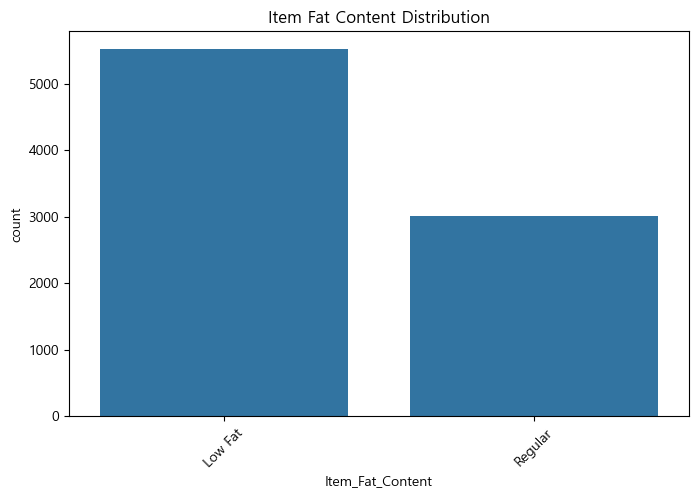

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.countplot(x=bigmt["Item_Fat_Content"])
plt.xticks(rotation=45)
plt.title("Item Fat Content Distribution")
plt.show()

### 제품 유형별 분포 확인

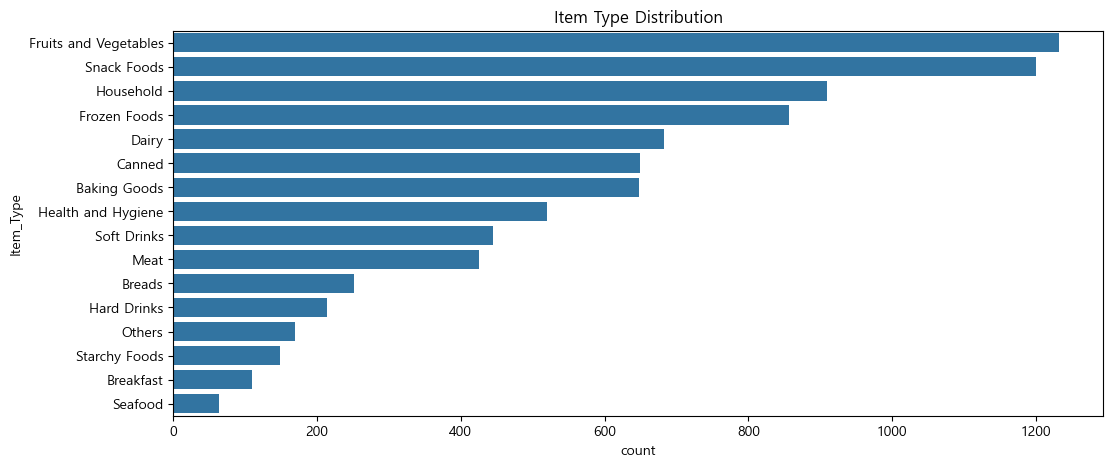

In [15]:
plt.figure(figsize=(12, 5))
sns.countplot(y=bigmt["Item_Type"], order=bigmt["Item_Type"].value_counts().index)
plt.title("Item Type Distribution")
plt.show()

### 제품 유형을 상품의 특성으로 그룹화하기

In [16]:
category_map = {
    'Dairy': 'Dairy',
    'Soft Drinks': 'Beverages',
    'Hard Drinks': 'Beverages',
    'Meat': 'Meat',
    'Fruits and Vegetables': 'Produce',
    'Baking Goods': 'Baking',
    'Snack Foods': 'Snacks',
    'Frozen Foods': 'Frozen',
    'Breakfast': 'Breakfast',
    'Canned': 'Canned',
    'Breads': 'Breads',
    'Starchy Foods': 'Starchy',
    'Seafood': 'Seafood',
    'Household': 'Non-Food',
    'Health and Hygiene': 'Non-Food',
    'Others': 'Non-Food'
}
bigmt['Item_Type'] = bigmt['Item_Type'].map(category_map)

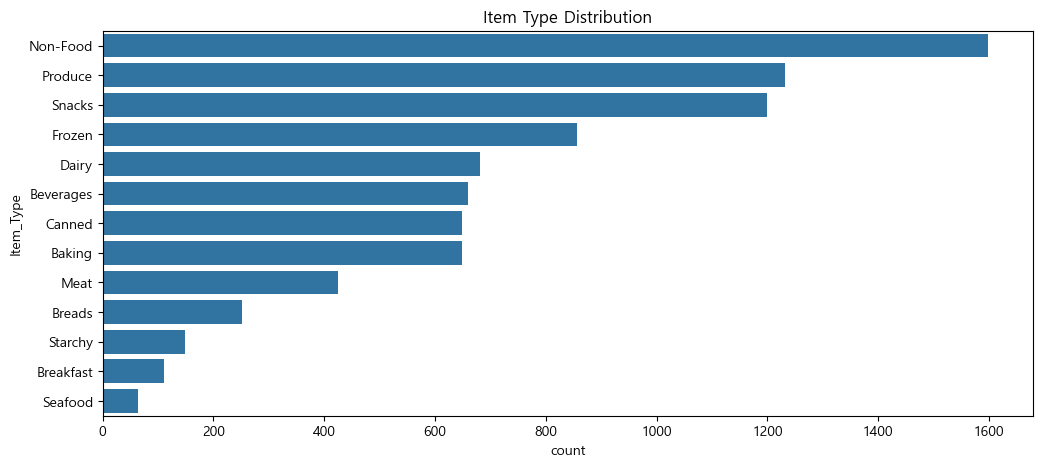

In [17]:
plt.figure(figsize=(12, 5))
sns.countplot(y=bigmt["Item_Type"], order=bigmt["Item_Type"].value_counts().index)
plt.title("Item Type Distribution")
plt.show()

### 매장 식별자 시각화

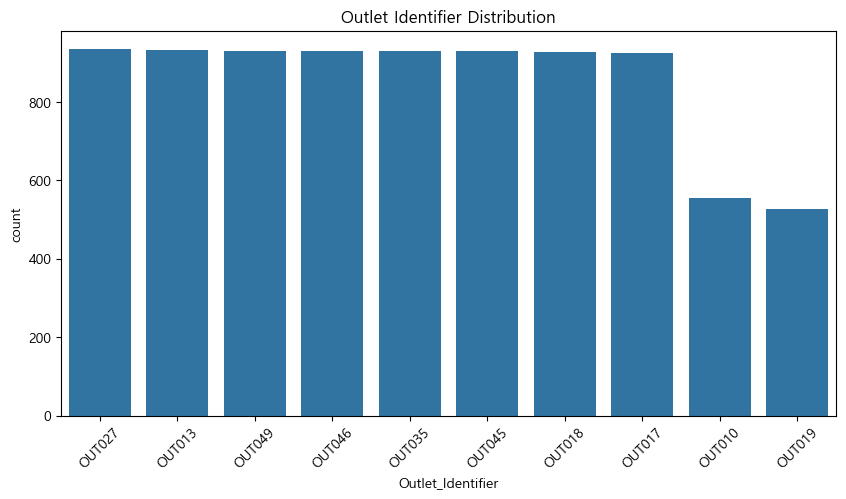

In [18]:
plt.figure(figsize=(10, 5))
sns.countplot(x=bigmt["Outlet_Identifier"], order=bigmt["Outlet_Identifier"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Outlet Identifier Distribution")
plt.show()

### 매장별 사이즈 시각화

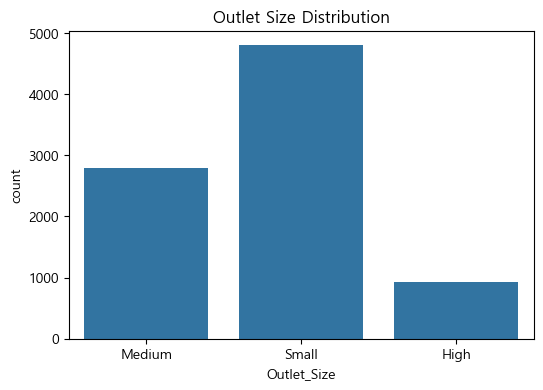

In [19]:
plt.figure(figsize=(6, 4))
sns.countplot(x=bigmt["Outlet_Size"])
plt.title("Outlet Size Distribution")
plt.show()

### 매장 위치 분포

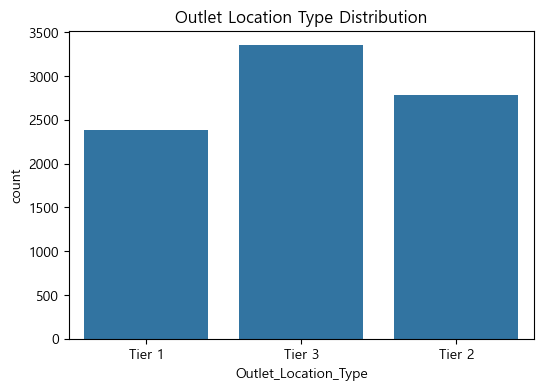

In [20]:
plt.figure(figsize=(6, 4))
sns.countplot(x=bigmt["Outlet_Location_Type"])
plt.title("Outlet Location Type Distribution")
plt.show()

### 매장 유형별 분포

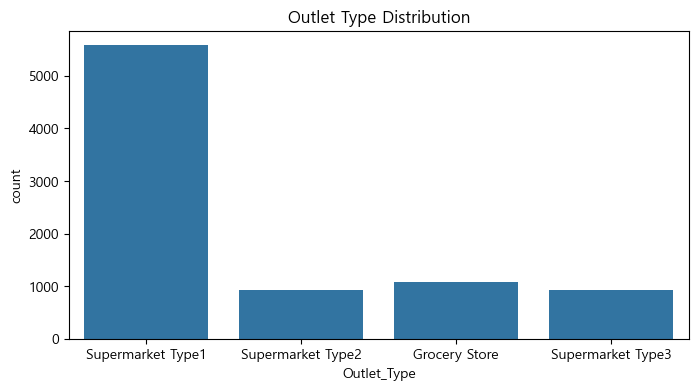

In [21]:
plt.figure(figsize=(8, 4))
sns.countplot(x=bigmt["Outlet_Type"])
plt.title("Outlet Type Distribution")
plt.show()

### 수치형 데이터 이상치 확인

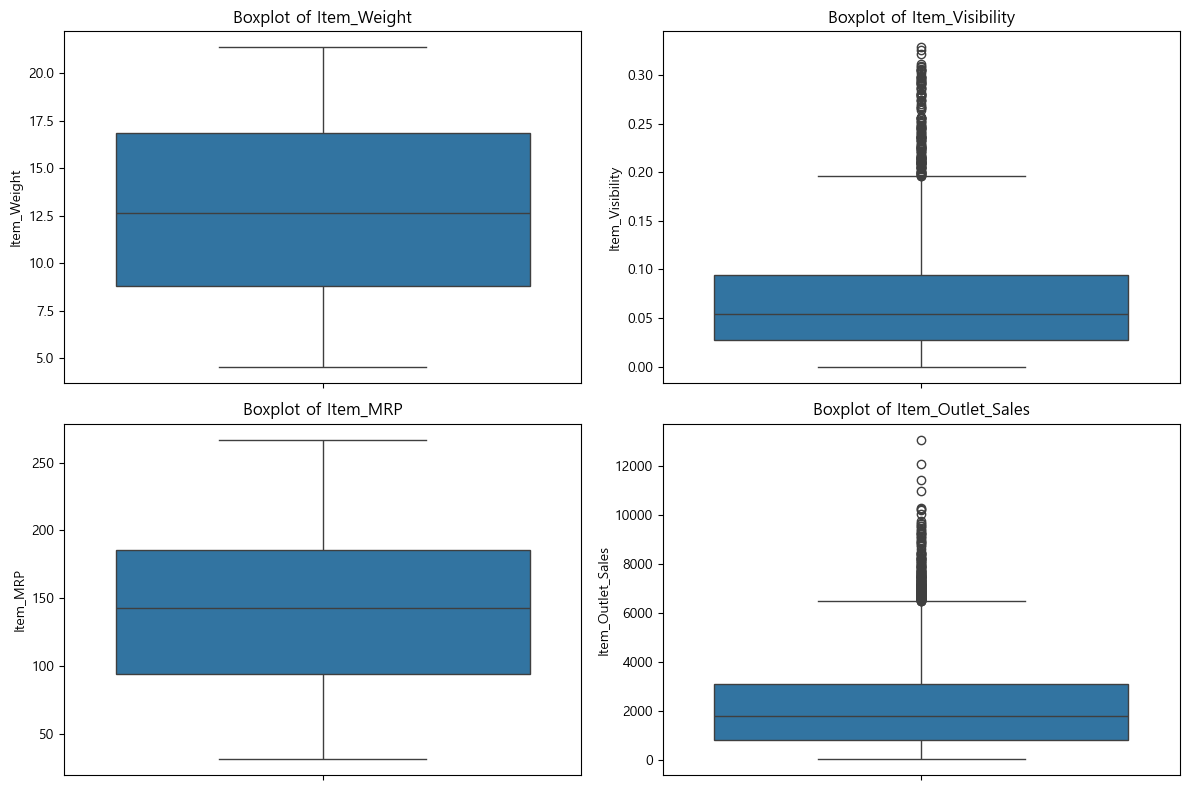

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 데이터 로드 
numeric_columns = ["Item_Weight", "Item_Visibility", "Item_MRP", "Item_Outlet_Sales"]

# 박스플롯 그리기
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=bigmt[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()


### 상품 노출도 이상치 전처리

In [23]:
# Item_Visibility가 0인 데이터 중에서 Item_Outlet_Sales가 0이 아닌 개수 확인
zero_visibility_sales = bigmt[(bigmt["Item_Visibility"] == 0.0) & (bigmt["Item_Outlet_Sales"] > 0)].shape[0]

print(f"Item_Visibility가 0인데 매출액이 있는 데이터 개수: {zero_visibility_sales}")


Item_Visibility가 0인데 매출액이 있는 데이터 개수: 526


In [24]:
# 1단계 같은 상품 + 같은 매장 에서의 평균값으로 채우기
bigmt['Item_Visibility'] = bigmt.groupby(['Item_Identifier', 'Outlet_Identifier'])['Item_Visibility'].transform(
    lambda x: x.replace(0, x.mean())
)

# 2단계 같은 상품 유형의 평균 값으로 채우기.
bigmt['Item_Visibility'] = bigmt.groupby('Item_Type')['Item_Visibility'].transform(
    lambda x: x.replace(0, x.mean())
)


In [25]:
zero_Visibility = (bigmt['Item_Visibility'] == 0.0).sum()
print(f"Item_Visibility가 0인 데이터 개수: {zero_Visibility}")

Item_Visibility가 0인 데이터 개수: 0


## 상관관계 분석

### 수치형 데이터

Item_Outlet_Sales            1.000000
Item_MRP                     0.567574
Item_Weight                  0.013198
Outlet_Establishment_Year   -0.049135
Item_Visibility             -0.133937
Name: Item_Outlet_Sales, dtype: float64


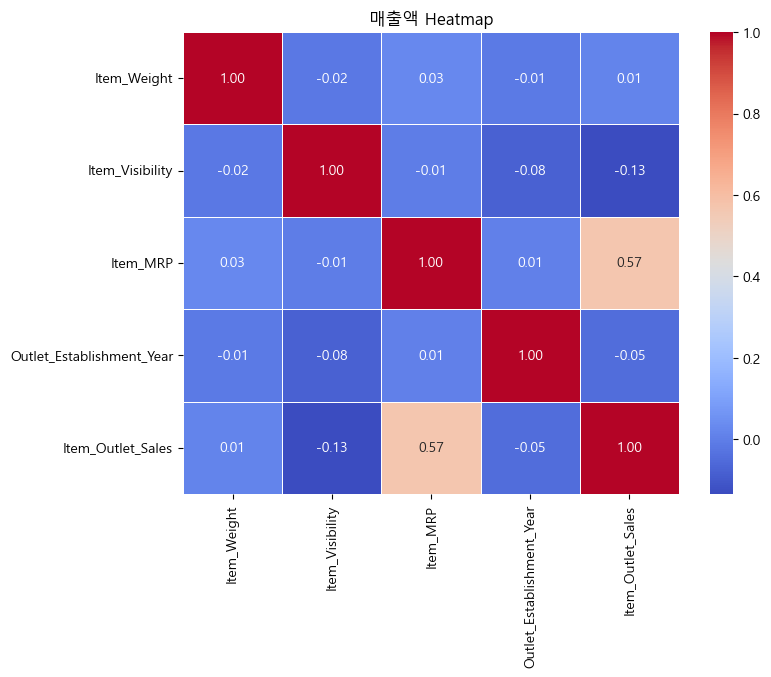

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# 한글 폰트 설정
plt.rc('font', family='Malgun Gothic')  # Windows (맑은 고딕)
mpl.rcParams['axes.unicode_minus'] = False  # 유니코드 마이너스 기호 문제 해결

# 숫자형 데이터만 선택
num_cols =  ["Item_Weight", "Item_Visibility", "Item_MRP", "Outlet_Establishment_Year", "Item_Outlet_Sales"]

#상관계수 계산
corr_matrix = bigmt[num_cols].corr()

# 매출액 와 다른 변수들의 상관관계 계산
sales_corr = corr_matrix['Item_Outlet_Sales'].sort_values(ascending=False)

#상관계수 출력
print(sales_corr)

#히트맵 시각화
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('매출액 Heatmap')
plt.show()

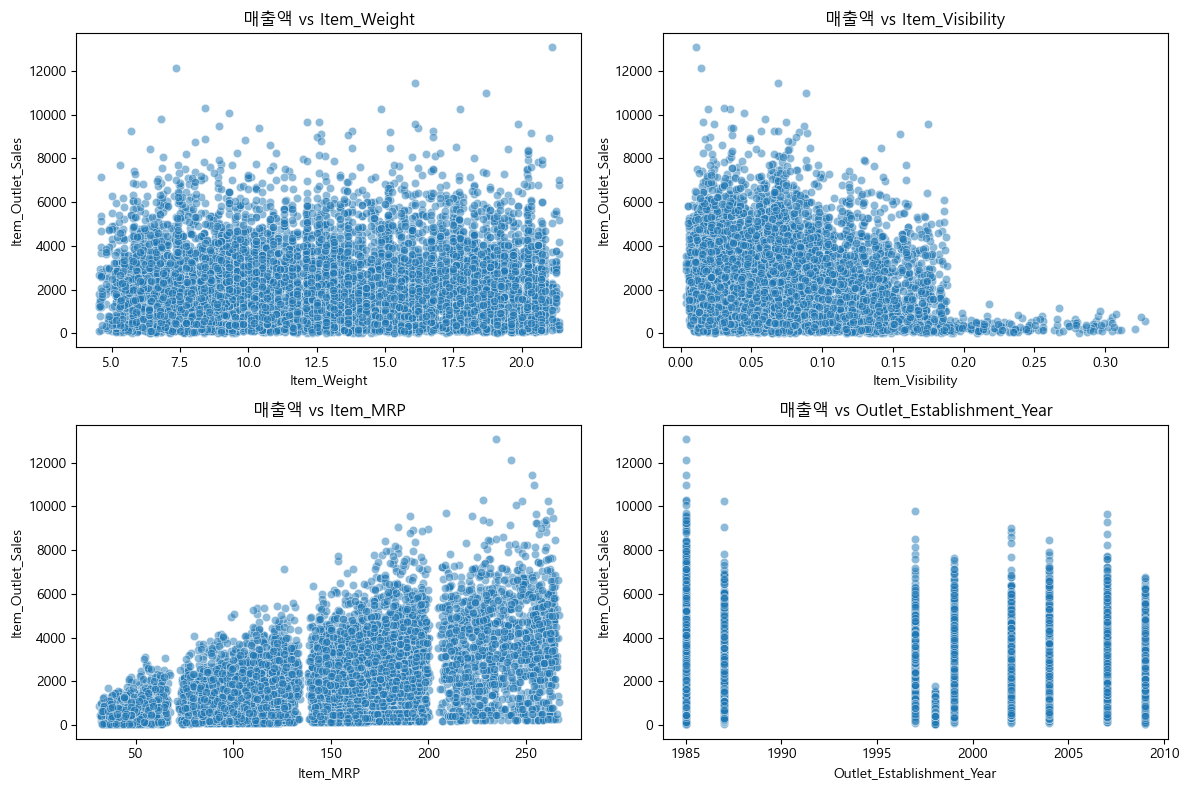

In [27]:
# 산점도 그래프 (scatter plot)
num_cols = ["Item_Weight", "Item_Visibility", "Item_MRP", "Outlet_Establishment_Year"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=bigmt[col], y=bigmt["Item_Outlet_Sales"], alpha=0.5)
    plt.title(f"매출액 vs {col}")

plt.tight_layout()
plt.show()

### 범주형 데이터

In [28]:
bigmt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                8523 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                8523 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


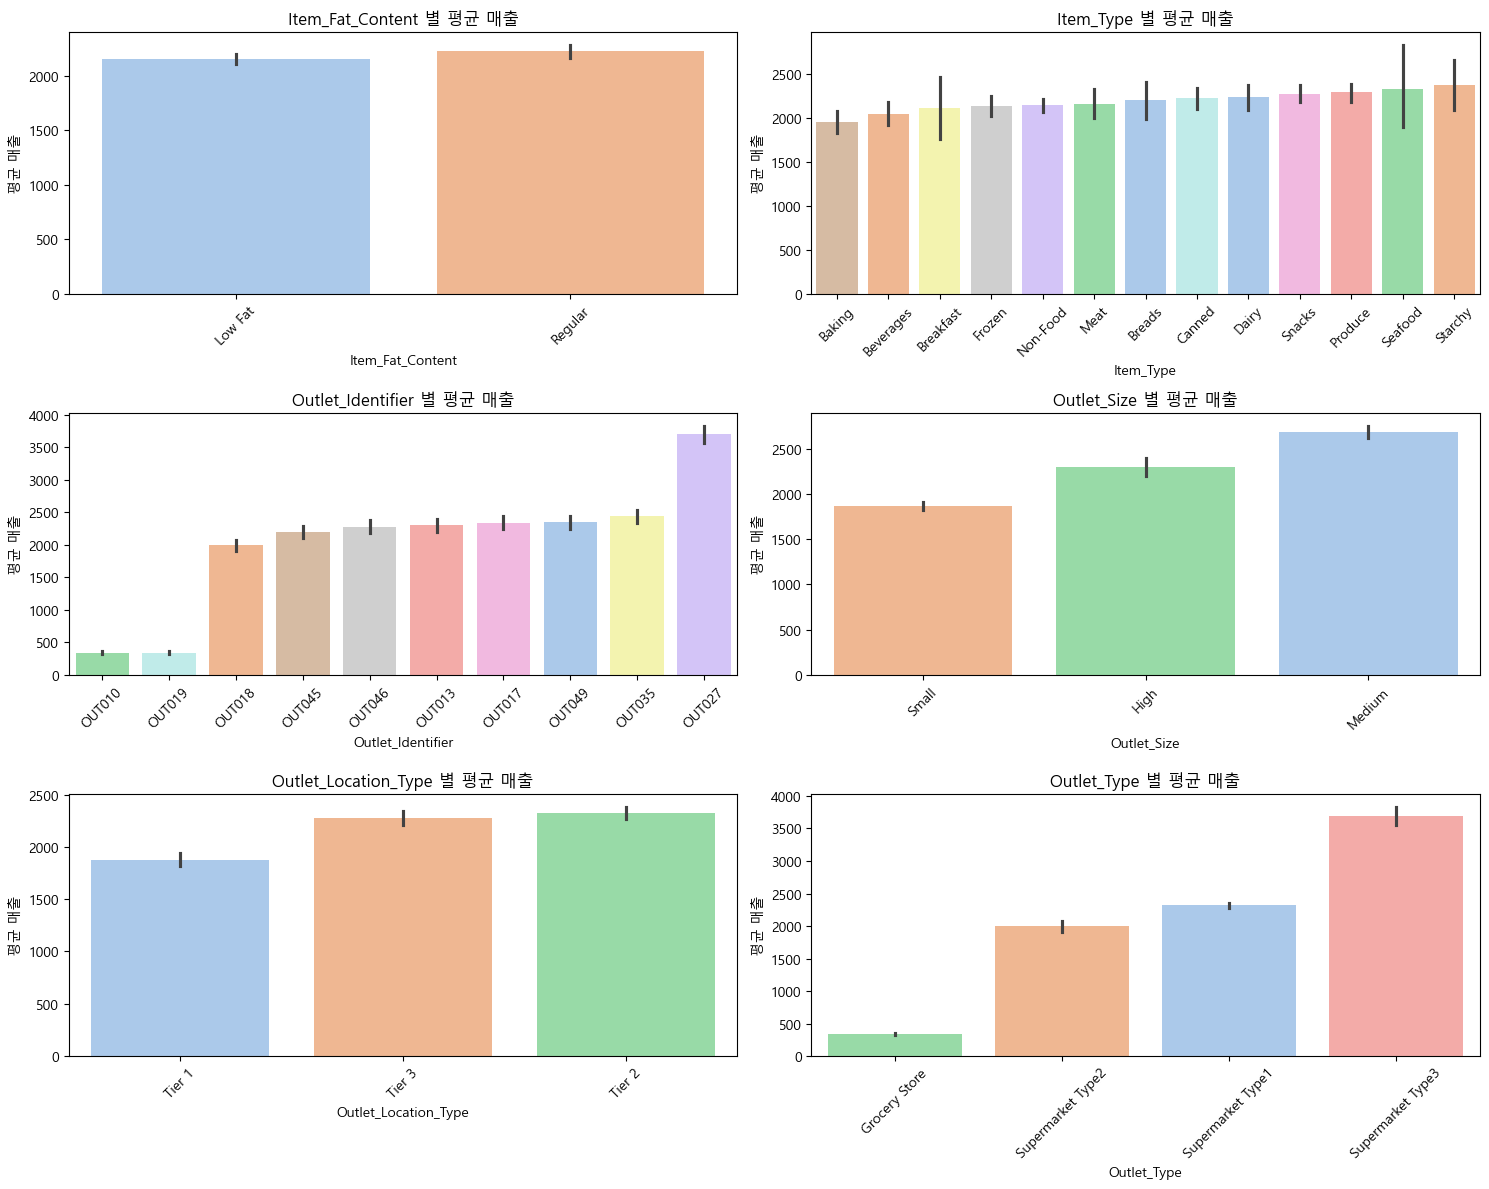

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 범주형 변수 리스트
categorical_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
                   'Outlet_Size','Outlet_Location_Type','Outlet_Type']

# 그래프 크기 설정
plt.figure(figsize=(15,12))

# 각 범주별 평균 매출 확인
for i,col in enumerate(categorical_cols, 1):
    plt.subplot(3, 2, i)
    order = bigmt.groupby(col)['Item_Outlet_Sales'].mean().sort_values().index # 평귱 매출 기준 정렬
    sns.barplot(x=col, y='Item_Outlet_Sales', hue=col, data=bigmt, order=order, palette='pastel', legend=False)
    plt.xticks(rotation=45)
    plt.title(f'{col} 별 평균 매출')
    plt.ylabel('평균 매출')

plt.tight_layout()
plt.show()

### 카이제곱 검정

In [30]:
import scipy.stats as stats

cat_cols = ['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
                   'Outlet_Size','Outlet_Location_Type','Outlet_Type']

for col in cat_cols:
    groups = [bigmt[bigmt[col] == category]["Item_Outlet_Sales"] for category in bigmt[col].unique()]
    
    # Kruskal-Wallis 검정 수행
    h_stat, p_value = stats.kruskal(*groups)
    
    print(f" {col} vs Item_Outlet_Sales | H-stat: {h_stat:.2f} | p-value: {p_value:.5f}")


 Item_Fat_Content vs Item_Outlet_Sales | H-stat: 3.01 | p-value: 0.08287
 Item_Type vs Item_Outlet_Sales | H-stat: 30.36 | p-value: 0.00246
 Outlet_Identifier vs Item_Outlet_Sales | H-stat: 2814.46 | p-value: 0.00000
 Outlet_Size vs Item_Outlet_Sales | H-stat: 456.73 | p-value: 0.00000
 Outlet_Location_Type vs Item_Outlet_Sales | H-stat: 155.51 | p-value: 0.00000
 Outlet_Type vs Item_Outlet_Sales | H-stat: 2803.36 | p-value: 0.00000


### 전처리 완료 컬럼

In [31]:
df = bigmt.copy()

df.drop(columns=['Item_Identifier', 'Item_Weight', 'Item_Fat_Content'], inplace=True)
df.head()

,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,0.019278,Beverages,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,0.068513,Produce,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,0.059222,Non-Food,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


## 회귀 모델 

### 선형회귀

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 원-핫 인코딩 적용 (범주형 컬럼 변환)
df_encoded = pd.get_dummies(df, columns=['Item_Type', 'Outlet_Identifier', 'Outlet_Size', 
                                         'Outlet_Location_Type', 'Outlet_Type'])

# 독립 변수(X)와 종속 변수(y) 설정
X = df_encoded.drop(columns=['Item_Outlet_Sales'])
y = df_encoded['Item_Outlet_Sales']

# 학습 데이터와 검증 데이터로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 선형 회귀 모델 생성 및 학습
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# 예측 수행
y_pred = lr_model.predict(X_valid)

# 평가지표 계산
r2 = r2_score(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred)

# 훈련 데이터 R² Score
train_r2 = lr_model.score(X_train, y_train)

# 결과 출력
print(f"훈련 데이터 R² Score : {train_r2:.4f}")
print(f"검증 데이터 R² Score : {r2:.4f}")
print(f"검증 데이터 MSE  : {mse:.4f}")
print(f"검증 데이터 RMSE : {rmse:.4f}")
print(f"검증 데이터 MAE  : {mae:.4f}")


훈련 데이터 R² Score : 0.5592
검증 데이터 R² Score : 0.5798
검증 데이터 MSE  : 1142092.5900
검증 데이터 RMSE : 1068.6873
검증 데이터 MAE  : 791.3860


### 랜덤포레스트

In [33]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 라벨 인코딩 적용 컬럼
cat_cols = ['Item_Type', 'Outlet_Identifier', 'Outlet_Size','Outlet_Location_Type', 'Outlet_Type']

# 라벨 인코딩 수행
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# 독립 변수 와 종속 변수 설정
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

# 학습 데이터 검증 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

#랜덤 포레스트 모델 생성 및 학습
rf_model = RandomForestRegressor(
    n_estimators=150,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='log2',
    max_depth=10,
    random_state=42
)
rf_model.fit(X_train, y_train)

# 예측 수행
y_pred = rf_model.predict(X_valid)

# 평가 지표 계산
r2 = r2_score(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred)

#훈련 데이터  R² Score
train_r2 = rf_model.score(X_train, y_train)

# 결과 출력
print(f"훈련 데이터 R² Score : {train_r2:.4f}")
print(f"검증 데이터 R² Score : {r2:.4f}")
print(f"검증 데이터 MSE  : {mse:.4f}")
print(f"검증 데이터 RMSE : {rmse:.4f}")
print(f"검증 데이터 MAE  : {mae:.4f}")

훈련 데이터 R² Score : 0.6827
검증 데이터 R² Score : 0.6205
검증 데이터 MSE  : 1031597.6595
검증 데이터 RMSE : 1015.6760
검증 데이터 MAE  : 713.0130


### ExtraTreesRegressor

In [34]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 원-핫 인코딩 적용 (범주형 컬럼 변환)
df_encoded = pd.get_dummies(df, columns=['Item_Type', 'Outlet_Identifier', 'Outlet_Size', 
                                         'Outlet_Location_Type', 'Outlet_Type'])

# 독립 변수(X)와 종속 변수(y) 설정
X = df_encoded.drop(columns=['Item_Outlet_Sales'])
y = df_encoded['Item_Outlet_Sales']

# 학습 데이터와 검증 데이터로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# ExtraTreesRegressor 모델 학습
et_model = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=7,
    random_state=42
)
et_model.fit(X_train, y_train)

# 예측 수행
y_pred = et_model.predict(X_valid)

# 평가지표 계산
r2 = r2_score(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred)

# 훈련 데이터 R² Score
train_r2 = et_model.score(X_train, y_train)

# 결과 출력
print(f"훈련 데이터 R² Score : {train_r2:.4f}")
print(f"검증 데이터 R² Score : {r2:.4f}")
print(f"검증 데이터 MSE  : {mse:.4f}")
print(f"검증 데이터 RMSE : {rmse:.4f}")
print(f"검증 데이터 MAE  : {mae:.4f}")


훈련 데이터 R² Score : 0.6141
검증 데이터 R² Score : 0.6194
검증 데이터 MSE  : 1034580.5747
검증 데이터 RMSE : 1017.1433
검증 데이터 MAE  : 710.4974


### Gradient Boosting

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 원-핫 인코딩 적용 (범주형 컬럼 변환)
df_encoded = pd.get_dummies(df, columns=['Item_Type', 'Outlet_Identifier', 'Outlet_Size', 
                                         'Outlet_Location_Type', 'Outlet_Type'])

# 독립 변수(X)와 종속 변수(y) 설정
X = df_encoded.drop(columns=['Item_Outlet_Sales'])
y = df_encoded['Item_Outlet_Sales']


# 학습 데이터와 검증 데이터로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# GradientBoostingRegressor 모델 학습
gb_model = GradientBoostingRegressor(
    n_estimators = 150,
    learning_rate=0.05,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=8,
    random_state=42
)
gb_model.fit(X_train, y_train)

# 예측 수행
y_pred = gb_model.predict(X_valid)

# 평가지표 계산
r2 = r2_score(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred)

# 훈련 데이터 R² Score
train_r2 = gb_model.score(X_train, y_train)

# 결과 출력
print(f"훈련 데이터 R² Score : {train_r2:.4f}")
print(f"검증 데이터 R² Score : {r2:.4f}")
print(f"검증 데이터 MSE  : {mse:.4f}")
print(f"검증 데이터 RMSE : {rmse:.4f}")
print(f"검증 데이터 MAE  : {mae:.4f}")

훈련 데이터 R² Score : 0.6230
검증 데이터 R² Score : 0.6158
검증 데이터 MSE  : 1044376.2126
검증 데이터 RMSE : 1021.9473
검증 데이터 MAE  : 716.0089


### HistGradientBoosting

In [36]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 원-핫 인코딩 적용 (범주형 컬럼 변환)
df_encoded = pd.get_dummies(df, columns=['Item_Type', 'Outlet_Identifier', 'Outlet_Size', 
                                         'Outlet_Location_Type', 'Outlet_Type'])

# 독립 변수(X)와 종속 변수(y) 설정
X = df_encoded.drop(columns=['Item_Outlet_Sales'])
y = df_encoded['Item_Outlet_Sales']


# 학습 데이터와 검증 데이터로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# HistGradientBoosting 모델 학습
hgb_model = HistGradientBoostingRegressor(
    max_iter=150,
    learning_rate=0.073,
    max_depth=2,
    min_samples_leaf=4,
    random_state=42
)
hgb_model.fit(X_train, y_train)

# 예측 수행
y_pred = hgb_model.predict(X_valid)

# 평가지표 계산
r2 = r2_score(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred)

# 훈련 데이터 R² Score
train_r2 = hgb_model.score(X_train, y_train)

# 결과 출력
print(f"훈련 데이터 R² Score : {train_r2:.4f}")
print(f"검증 데이터 R² Score : {r2:.4f}")
print(f"검증 데이터 MSE  : {mse:.4f}")
print(f"검증 데이터 RMSE : {rmse:.4f}")
print(f"검증 데이터 MAE  : {mae:.4f}")

훈련 데이터 R² Score : 0.6110
검증 데이터 R² Score : 0.6171
검증 데이터 MSE  : 1040725.5475
검증 데이터 RMSE : 1020.1596
검증 데이터 MAE  : 717.7117


### XGBoost

In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# 라벨 인코딩 적용 컬럼
cat_cols = ['Item_Type', 'Outlet_Identifier', 'Outlet_Size','Outlet_Location_Type', 'Outlet_Type']

# 라벨 인코딩 수행
encoder = LabelEncoder()
for col in cat_cols:
    df[col] = encoder.fit_transform(df[col])

# 독립 변수 와 종속 변수 설정
X = df.drop(columns=['Item_Outlet_Sales'])
y = df['Item_Outlet_Sales']

# 학습 데이터 검증 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 모델 학습
xgb_model = XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.08,
    max_depth = 3,
    min_child_weight = 7,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# 예측 수행
y_pred = xgb_model.predict(X_valid)

# 평가지표 계산
r2 = r2_score(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred)

# 훈련 데이터 R² Score
train_r2 = xgb_model.score(X_train, y_train)

# 결과 출력
print(f"훈련 데이터 R² Score : {train_r2:.4f}")
print(f"검증 데이터 R² Score : {r2:.4f}")
print(f"검증 데이터 MSE  : {mse:.4f}")
print(f"검증 데이터 RMSE : {rmse:.4f}")
print(f"검증 데이터 MAE  : {mae:.4f}")

훈련 데이터 R² Score : 0.6195
검증 데이터 R² Score : 0.6166
검증 데이터 MSE  : 1041998.4849
검증 데이터 RMSE : 1020.7833
검증 데이터 MAE  : 714.8805


### LightGBM

In [38]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# 원-핫 인코딩 적용 (범주형 컬럼 변환)
df_encoded = pd.get_dummies(df, columns=['Item_Type', 'Outlet_Identifier', 'Outlet_Size', 
                                         'Outlet_Location_Type', 'Outlet_Type'])

# 독립 변수(X)와 종속 변수(y) 설정
X = df_encoded.drop(columns=['Item_Outlet_Sales'])
y = df_encoded['Item_Outlet_Sales']


# 학습 데이터와 검증 데이터로 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM 모델 학습
lgb_model = lgb.LGBMRegressor(
    n_estimators = 150, learning_rate = 0.03,
    max_depth = 4, num_leaves = 150,
    min_child_sample = 5,verbose = -1,
    random_state=42
)
lgb_model.fit(X_train, y_train)

# 예측 수행
y_pred = lgb_model.predict(X_valid)

# 평가지표 계산
r2 = r2_score(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred)

# 훈련 데이터 R² Score
train_r2 = lgb_model.score(X_train, y_train)

# 결과 출력
print(f"훈련 데이터 R² Score : {train_r2:.4f}")
print(f"검증 데이터 R² Score : {r2:.4f}")
print(f"검증 데이터 MSE  : {mse:.4f}")
print(f"검증 데이터 RMSE : {rmse:.4f}")
print(f"검증 데이터 MAE  : {mae:.4f}")

훈련 데이터 R² Score : 0.6178
검증 데이터 R² Score : 0.6172
검증 데이터 MSE  : 1040530.2925
검증 데이터 RMSE : 1020.0639
검증 데이터 MAE  : 714.3398


### csv 파일로 다운받기

In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### (1) 라벨 인코딩 적용 ###
df_label = df.copy()
label_cols = ['Item_Type', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']
encoder = LabelEncoder()

for col in label_cols:
    df_label[col] = encoder.fit_transform(df_label[col])

# X, y 설정
X_label = df_label.drop(columns=['Item_Outlet_Sales'])
y_label = df_label['Item_Outlet_Sales']

# 학습 데이터와 검증 데이터로 분리
X_train_label, X_valid_label, y_train_label, y_valid_label = train_test_split(X_label, y_label, test_size=0.2, random_state=42)

# 라벨 인코딩을 사용하는 모델 리스트
label_models = {
    "Random Forest": RandomForestRegressor(n_estimators=150, min_samples_split=5, min_samples_leaf=3, max_features='log2', max_depth=10, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.08, max_depth=3, min_child_weight = 7, random_state=42)
}

# 결과 저장 리스트
label_results = []

for name, model in label_models.items():
    model.fit(X_train_label, y_train_label)
    y_pred_label = model.predict(X_valid_label)
    
    # 성능 평가
    r2 = r2_score(y_valid_label, y_pred_label)
    mse = mean_squared_error(y_valid_label, y_pred_label)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid_label, y_pred_label)
    train_r2 = model.score(X_train_label, y_train_label)
    
    # 결과 저장
    label_results.append([name, train_r2, r2, mse, rmse, mae])

df_label_results = pd.DataFrame(label_results, columns=["Model", "Train R²", "valid R²", "MSE", "RMSE", "MAE"])

### (2) 원-핫 인코딩 적용 ###
df_onehot = pd.get_dummies(df, columns=label_cols)

# X, y 설정
X_onehot = df_onehot.drop(columns=['Item_Outlet_Sales'])
y_onehot = df_onehot['Item_Outlet_Sales']

# 학습 데이터와 검증 데이터로 분리
X_train_onehot, X_valid_onehot, y_train_onehot, y_valid_onehot = train_test_split(X_onehot, y_onehot, test_size=0.2, random_state=42)

# 원-핫 인코딩을 사용하는 모델 리스트
onehot_models = {
    "Linear Regression": LinearRegression(),
    "Extra Trees": ExtraTreesRegressor(n_estimators=300, max_depth=7, min_samples_split=10, min_samples_leaf=7, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=150, learning_rate=0.05, max_depth=3, min_samples_split=5, min_samples_leaf=8, random_state=42),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(max_iter=150, learning_rate=0.073, max_depth=2, min_samples_leaf=4, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators = 150, learning_rate = 0.03,max_depth = 4, num_leaves = 150,min_child_sample = 5,verbose = -1,random_state=42)
}

# 결과 저장 리스트
onehot_results = []

for name, model in onehot_models.items():
    model.fit(X_train_onehot, y_train_onehot)
    y_pred_onehot = model.predict(X_valid_onehot)
    
    # 성능 평가
    r2 = r2_score(y_valid_onehot, y_pred_onehot)
    mse = mean_squared_error(y_valid_onehot, y_pred_onehot)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_valid_onehot, y_pred_onehot)
    train_r2 = model.score(X_train_onehot, y_train_onehot)
    
    # 결과 저장
    onehot_results.append([name, train_r2, r2, mse, rmse, mae])

df_onehot_results = pd.DataFrame(onehot_results, columns=["Model", "Train R²", "valid R²", "MSE", "RMSE", "MAE"])

# 결과 합치기
df_final_results = pd.concat([df_label_results, df_onehot_results], axis=0)

# 모델 순서 지정 (이 부분 추가!)
model_order = [
    "Linear Regression",
    "Random Forest",
    "Extra Trees",
    "Gradient Boosting",
    "Hist Gradient Boosting",
    "XGBoost",
    "LightGBM"
]

# 원하는 순서로 정렬
df_final_results["Model"] = pd.Categorical(df_final_results["Model"], categories=model_order, ordered=True)
df_final_results = df_final_results.sort_values("Model").reset_index(drop=True)

# CSV로 저장
df_final_results.to_csv("model_results.csv", index=False)

print("model_results.csv 파일에 저장되었습니다!")

model_results.csv 파일에 지정한 순서로 저장되었습니다!


### 모델별 회귀 성능 지표 시각화

#### Valid R² 비교

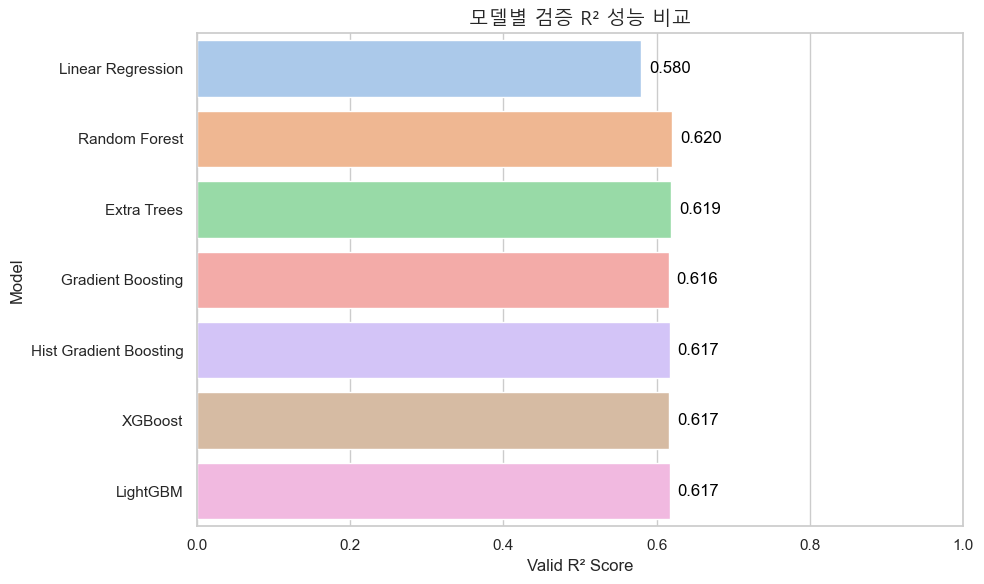

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.font_manager as fm

# 맑은 고딕 폰트 경로 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# 전체 그래프 설정에 맑은 고딕 적용
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# Seaborn 스타일에도 한글 폰트 지정
sns.set(font=font_prop.get_name())

valid = pd.read_csv("model_results.csv")

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

barplot = sns.barplot(data=valid, x='valid R²', y='Model', hue='Model', palette='pastel', legend=False)

# 값 레이블
for i, v in enumerate(valid['valid R²']):
    plt.text(v + 0.01, i, f"{v:.3f}", color='black', va='center')

plt.title('모델별 검증 R² 성능 비교', fontproperties=font_prop, fontsize=14)
plt.xlabel('Valid R² Score')
plt.ylabel('Model')
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

#### MSE/ RMSE/ MAE 비교 시각화

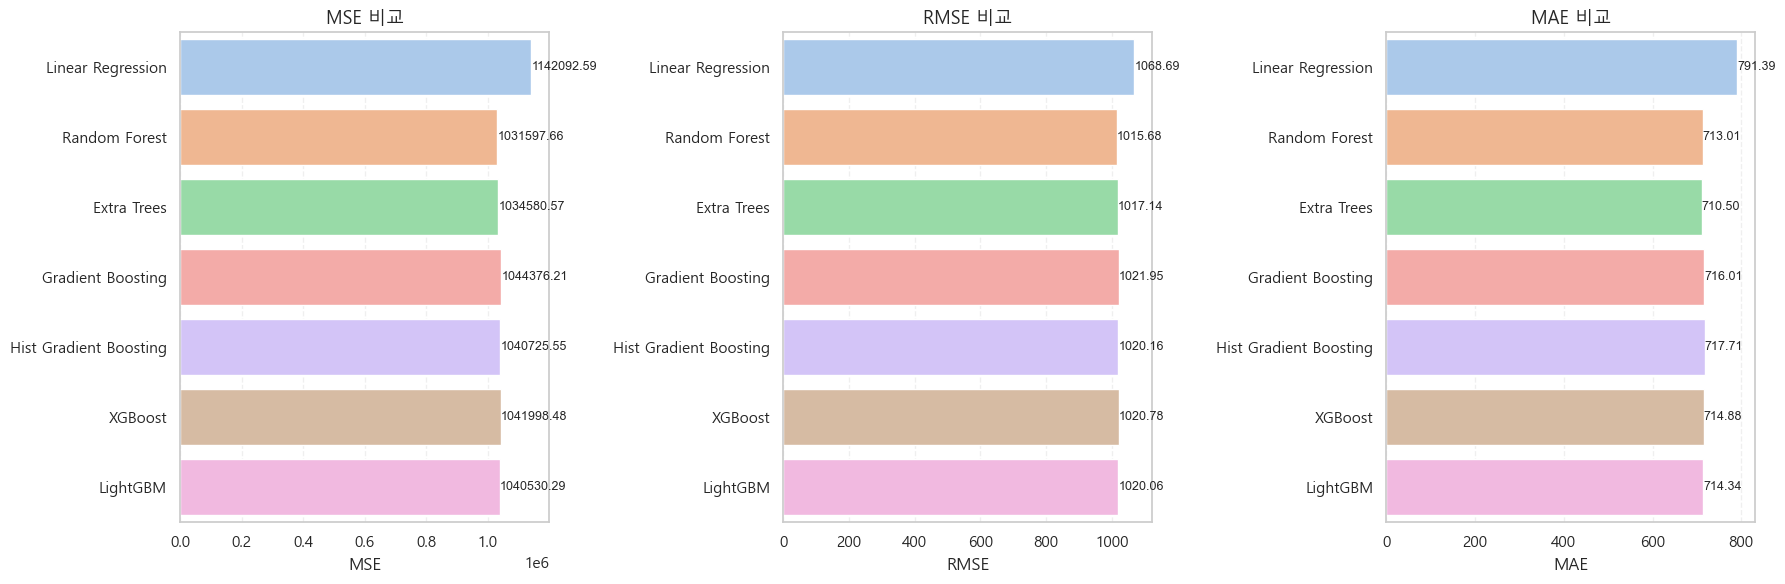

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import font_manager, rc

# 한글 폰트 설정 - 맑은 고딕 사용
font_path = "C:/Windows/Fonts/malgun.ttf"  # 맑은 고딕 경로
font_prop = font_manager.FontProperties(fname=font_path).get_name()
plt.rcParams['font.family'] = font_prop
plt.rcParams['axes.unicode_minus'] = False

MRM = pd.read_csv("model_results.csv")

metrics = ['MSE', 'RMSE', 'MAE']
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
sns.set_style("whitegrid")

for i, metric in enumerate(metrics):
    # hue='Model' 추가, dodge=False는 그룹핑 없이 바로 y 기준으로 색 구분
    sns.barplot(data=MRM, x=metric, y='Model', hue='Model',
                dodge=False, palette='pastel', ax=axes[i], legend=False)
    
    for j, v in enumerate(MRM[metric]):
        axes[i].text(v, j, f"{v:.2f}", va='center', ha='left', fontsize=9)

    axes[i].set_title(f'{metric} 비교', fontsize=13)
    axes[i].set_xlabel(metric)
    axes[i].set_ylabel('')
    axes[i].grid(axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


#### Train VS Valid R² 시각화

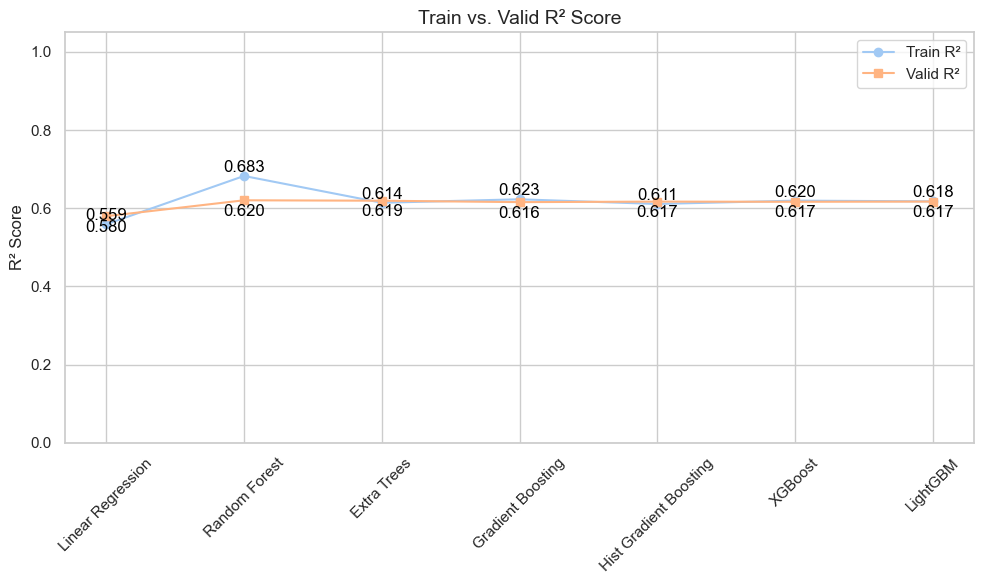

In [42]:
R2 = pd.read_csv("model_results.csv")

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

x = range(len(R2))
models = R2['Model']

# 파스텔톤 마커 라인 그래프
plt.plot(x, R2['Train R²'], marker='o', label='Train R²', color=sns.color_palette('pastel')[0])
plt.plot(x, R2['valid R²'], marker='s', label='Valid R²', color=sns.color_palette('pastel')[1])

# 값 라벨 표시
for i, (t, v) in enumerate(zip(R2['Train R²'], R2['valid R²'])):
    plt.text(i, t + 0.01, f"{t:.3f}", ha='center', color='black')
    plt.text(i, v - 0.04, f"{v:.3f}", ha='center', color='black')

plt.xticks(x, models, rotation=45)
plt.title("Train vs. Valid R² Score", fontsize=14)
plt.ylabel("R² Score")
plt.ylim(0, 1.05)
plt.legend()
plt.tight_layout()
plt.show()

### bigmt_test.csv 파일로 매출액 예상하기

#### 전처리

In [43]:
test = pd.read_csv('bigmart_test.csv')

test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [44]:
### 상품 무게 결측치 리리
# Item_Identifier 와 Item_Type이 모두 같은 경우 평균값으로 채우기
test['Item_Weight'] = test.groupby(['Item_Identifier', 'Item_Type'])['Item_Weight'].transform(lambda x: x.fillna(x.mean()))

# 그래도 결측치 값이 있으면 Item_Type 기준 평균값 채우기
test['Item_Weight'] = test.groupby('Item_Type')['Item_Weight'].transform(lambda x: x.fillna(x.mean()))

### 매장 유형 결측치 처리
# 매장 유형과 위치 유형별로 Outlet_Size의 최빈값 계산
size_mode = test.groupby(["Outlet_Type", "Outlet_Location_Type"])["Outlet_Size"].agg(lambda x: x.mode()[0] if not x.mode().empty else "Unknown")

# 매장 유형 + 위치 유형 조합별 최빈값으로 채우기
def fill_outlet_size(row):
    if pd.isnull(row['Outlet_Size']):
        return size_mode.get((row['Outlet_Type'], row['Outlet_Location_Type']), 'Unknown')
    return row['Outlet_Size']

test['Outlet_Size'] = test.apply(fill_outlet_size, axis=1)

#그래도 채우지 못한 값은 최종적으로 'Unknown'으로 대체
test['Outlet_Size'] = test['Outlet_Size'].fillna('Unknown')

# 'Grocery Store' 이면서 Outlet_Size가 'Unknown'인 경우 'Small'로 채우기
test.loc[(test["Outlet_Type"] == "Grocery Store") & (test["Outlet_Size"] == "Unknown"), "Outlet_Size"] = "Small"

### 제품 유형을 상품 특성으로 그룹화
category_map = {
    'Dairy': 'Dairy',
    'Soft Drinks': 'Beverages',
    'Hard Drinks': 'Beverages',
    'Meat': 'Meat',
    'Fruits and Vegetables': 'Produce',
    'Baking Goods': 'Baking',
    'Snack Foods': 'Snacks',
    'Frozen Foods': 'Frozen',
    'Breakfast': 'Breakfast',
    'Canned': 'Canned',
    'Breads': 'Breads',
    'Starchy Foods': 'Starchy',
    'Seafood': 'Seafood',
    'Household': 'Non-Food',
    'Health and Hygiene': 'Non-Food',
    'Others': 'Non-Food'
}
test['Item_Type'] = test['Item_Type'].map(category_map)

### 상품 노출도 이상치 처리
# 1단계 같은 상품 + 같은 매장 에서의 평균값으로 채우기
test['Item_Visibility'] = test.groupby(['Item_Identifier', 'Outlet_Identifier'])['Item_Visibility'].transform(
    lambda x: x.replace(0, x.mean())
)

# 2단계 같은 상품 유형의 평균 값으로 채우기.
test['Item_Visibility'] = test.groupby('Item_Type')['Item_Visibility'].transform(
    lambda x: x.replace(0, x.mean())
)


In [45]:
test.drop(columns=['Item_Identifier','Item_Weight','Item_Fat_Content'], inplace = True)

In [46]:
test.head()

,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,0.007565,Snacks,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,0.038428,Dairy,87.3198,OUT017,2007,Small,Tier 2,Supermarket Type1
2,0.099575,Non-Food,241.7538,OUT010,1998,Small,Tier 3,Grocery Store
3,0.015388,Snacks,155.0340,OUT017,2007,Small,Tier 2,Supermarket Type1
4,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [52]:
# 1. 필요한 라이브러리
import pandas as pd
import numpy as np
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

train = df.copy()

# 원-핫 인코딩 적용 (범주형 컬럼 변환)
df_encoded = pd.get_dummies(train, columns=['Item_Type', 'Outlet_Identifier', 'Outlet_Size', 
                                         'Outlet_Location_Type', 'Outlet_Type'])

# 독립 변수(X)와 종속 변수(y) 설정
X = df_encoded.drop(columns=['Item_Outlet_Sales'])
y = df_encoded['Item_Outlet_Sales']

# train/valid 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 정의 및 학습
et_model = ExtraTreesRegressor(
    n_estimators=300,
    max_depth=7,
    min_samples_split=10,
    min_samples_leaf=7,
    random_state=42
)
et_model.fit(X_train, y_train)

# 성능 확인
y_pred = et_model.predict(X_valid)
print(f"MAE: {mean_absolute_error(y_valid, y_pred):.4f}")

test_df = test.copy()

# 원-핫 인코딩 동일하게 적용 (train 기준 column 맞춤)
test_encoded = pd.get_dummies(test_df, columns=['Item_Type', 'Outlet_Identifier', 'Outlet_Size',
                                                'Outlet_Location_Type', 'Outlet_Type'])

# train과 test 컬럼을 동일하게 맞춤 (누락된 컬럼은 0으로 채우기)
missing_cols = set(X.columns) - set(test_encoded.columns)
for col in missing_cols:
    test_encoded[col] = 0

# 컬럼 순서도 맞추기
test_encoded = test_encoded[X.columns]

# 4. 예측 수행
test_predictions = et_model.predict(test_encoded)

# 5. 예측 결과를 test_df에 추가
test_df['Item_Outlet_Sales'] = test_predictions

# 6. 결과 저장 (선택)
test_df.to_csv('bigmt_test 예측.csv', index=False)

print("bigmt_test 예측.csv 파일에 저장되었습니다!")

MAE: 710.4974
bigmt_test 예측.csv 파일에 저장되었습니다!


### 실제값과 예측값의 시각화

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화 스타일 설정
sns.set(style='whitegrid', palette='muted')

# 실제 매출 (train)
df_train = pd.read_csv("bigmart_train.csv")
actual = df_train["Item_Outlet_Sales"]

# 예측된 매출 (test)
df_test = pd.read_csv("bigmt_test 예측.csv")
predicted = df_test["Item_Outlet_Sales"]

#### 산점도

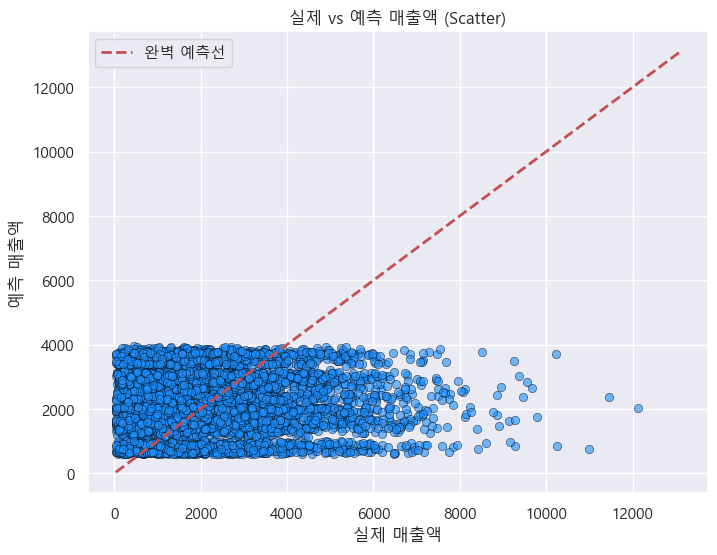

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.font_manager as fm

# 맑은 고딕 폰트 경로 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_prop = fm.FontProperties(fname=font_path)

# 전체 그래프 설정에 맑은 고딕 적용
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

# Seaborn 스타일에도 한글 폰트 지정
sns.set(font=font_prop.get_name())

plt.figure(figsize=(8, 6))
sns.scatterplot(x=actual, y=predicted, color='dodgerblue', alpha=0.6, edgecolor='black')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], 'r--', lw=2, label='완벽 예측선')
plt.title("실제 vs 예측 매출액 (Scatter)")
plt.xlabel("실제 매출액")
plt.ylabel("예측 매출액")
plt.legend()
plt.show()

#### 라인 플롯(일부 샘플 비교)

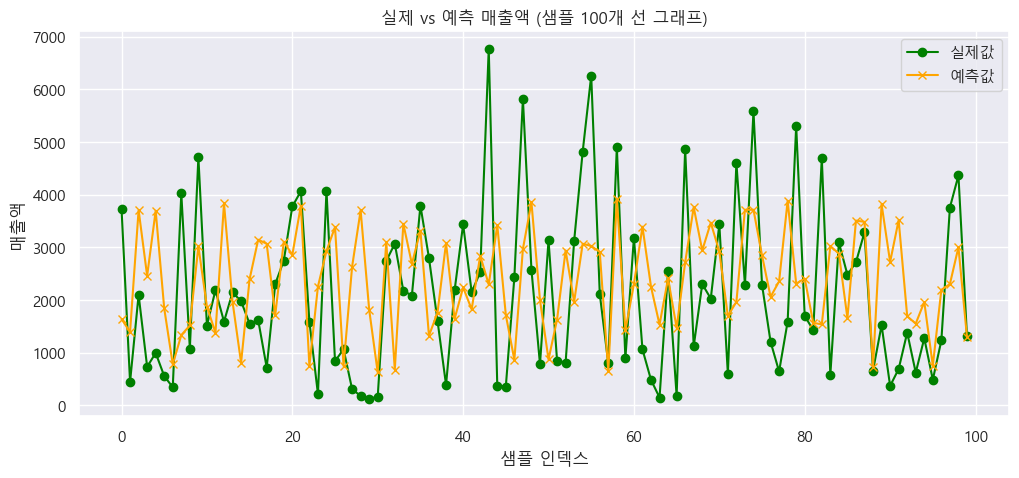

In [61]:
plt.figure(figsize=(12, 5))
sample_size = 100  # 앞에서 100개 샘플만 시각화
plt.plot(actual[:sample_size].values, label='실제값', marker='o', color='green')
plt.plot(predicted[:sample_size].values, label='예측값', marker='x', color='orange')
plt.title("실제 vs 예측 매출액 (샘플 100개 선 그래프)")
plt.xlabel("샘플 인덱스")
plt.ylabel("매출액")
plt.legend()
plt.show()

#### 오차 히스토그램

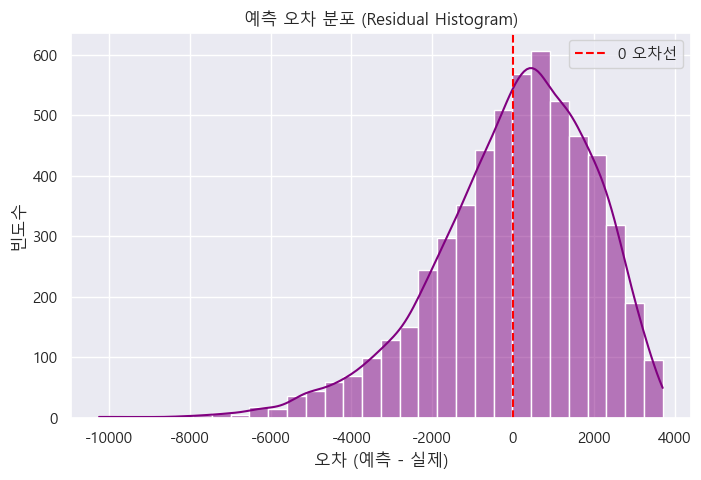

In [60]:
errors = predicted - actual
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=30, kde=True, color='purple', edgecolor='white')
plt.title("예측 오차 분포 (Residual Histogram)")
plt.xlabel("오차 (예측 - 실제)")
plt.ylabel("빈도수")
plt.axvline(0, color='red', linestyle='--', label='0 오차선')
plt.legend()
plt.show()